# Many body localization in 1-D qubit array

This simulation is based on the paper -- "Quantum Neuronal Sensing of Quantum Many-Body States on a 61-Qubit
Programmable Superconducting Processor", and aimed to demostrate the performance of quantum machine learning viaTeD-Q module. We further modify to 1-D qubit array to test the computing limit of the TeD-Q package
### Many Body localization
Many-body localization is a quantum phenomenon of an isolated many-body quantum system. The system tend to preserve the initial state under large disorder, known as localized state. On the other hand, with small disorder, the system tend to fall into the thermalization, that is, the infomation of initial state is washed out, known as ergodic state.

<img src="images/mbl_1d.png" width=600 />
(figure adapted from [2])

### Circuit design
The circuit design follows the one proposed in the paper. The circuit starts with an preparation stage for Neel state and followed by a system Hamiltonian with controllable disorder power. After that, the circuit is embeded with a variational cirucit via digital-analog architecture[1]. Finally, the measurement on first qubit is the output stage. We train the output probability to distinguish localized state from ergodic state.


### About this simulation
This circuit is suitable for the demostration of the computing power of TeD-Q package due to its complexity. In the simulated hamilonian of the system, the qubits was connected to all of its neighbor qubits. For a 1-D qubits array, such connection will introduce lot of 2-qubit operation and single-qubit operation, which becomes too complicated for the conventional quantum machine learning simulator.

## Reference
1. https://arxiv.org/pdf/2201.05957.pdf
2. https://arxiv.org/pdf/1804.11065.pdf
3. https://arxiv.org/pdf/1711.03145.pdf

In [1]:
import sys
sys.path.append('..')
import torch
import tedq as qai
import numpy as np
import math
from torch.optim import lr_scheduler
import torch.nn as nn

### init parameters

In [2]:
n_size = 3
n_epoch = 100
n_train = 200
n_test = 50

lr = 0.01
gamma_lr_scheduler = 0.2

n_qubits= n_size
t_d = 200e-9 #ns
h_bar = 1
g = 2.185e6 #MHz
h_erg = 1e6 # MHZ
h_loc = 40e6  # MHz

### Circuit definition

In [3]:
def getIndex(i, j):
    return n_size*i+j
def Hd(idx, jdx, di):
    #qai.RZ(2*h_bar*di*t_d, qubits=[jdx], trainable_params=[])
    qai.RZ(di, qubits=[jdx])
    H0(idx, jdx)
    
def H0(idx, jdx):
    qai.Hadamard(qubits=[idx])
    qai.Hadamard(qubits=[jdx])
    qai.CNOT(qubits=[idx, jdx])
    qai.RZ(torch.Tensor([g*h_bar*t_d]), qubits=[jdx], trainable_params=[])
    qai.CNOT(qubits=[idx, jdx])
    qai.Hadamard(qubits=[idx])
    qai.Hadamard(qubits=[jdx])
    
    qai.S(qubits=[idx])
    qai.S(qubits=[jdx])
    qai.Hadamard(qubits=[idx])
    qai.Hadamard(qubits=[jdx])
    qai.CNOT(qubits=[idx, jdx])
    qai.RZ(torch.Tensor([g*h_bar*t_d]), qubits=[jdx], trainable_params=[])
    qai.CNOT(qubits=[idx, jdx])
    qai.Hadamard(qubits=[idx])
    qai.Hadamard(qubits=[jdx])
    qai.PhaseShift(torch.tensor(-math.pi/2.), qubits=[idx], trainable_params=[])
    qai.PhaseShift(torch.tensor(-math.pi/2.), qubits=[jdx], trainable_params=[])

def partial_connected():
    for i in range(0, n_qubits-7, 5):
        qai.CNOT(qubits=[i, i+7])


def circuitDef(d, params):
    params = params.view(-1)
     
    # Neel state
    for i in range(n_qubits):
        if i%2==0:
            qai.PauliX(qubits=[i])
    
    # Hd td
    count = 0
    for i in range(n_qubits):
        if i>=0 and i+1<n_qubits:# (n_size-1)*n_size
            Hd(i+1, i, d[count])
            count+=1
        if i-1>=0 and i<n_qubits:# (n_size-1)*n_size
            Hd(i-1, i, d[count])
            count+=1    
            
    # Trainable theta and phi
    for i in range(n_qubits):
        #print(i)
        qai.RZ(params[2*i], qubits=[i])
        qai.RX(params[2*i+1], qubits=[i])
        qai.RZ(-params[2*i], qubits=[i])
    
    # Partial connection to increase complexity
    partial_connected()
    
    # H0 dt 
    for i in range(n_size):
        if i+1>=0 and i+1<n_qubits:# (n_size-1)*n_size
            H0(i+1, i)
        if i-1>=0 and i-1<n_qubits:# (n_size-1)*n_size
            H0(i-1, i)
            
    # Last rotation  
    qai.RZ(params[2*n_qubits], qubits=[n_qubits-1])
    qai.RX(params[2*n_qubits+1], qubits=[n_qubits-1])
    qai.RZ(-params[2*n_qubits], qubits=[n_qubits-1])

    # Measurement
    qai.measurement.probs(qubits=[n_qubits-1])
    


In [4]:
N = (n_size-1)*2

In [5]:
circuit = qai.Circuit(circuitDef, n_qubits, torch.rand(N), torch.rand(n_qubits+1,2))

### Draw the circuit

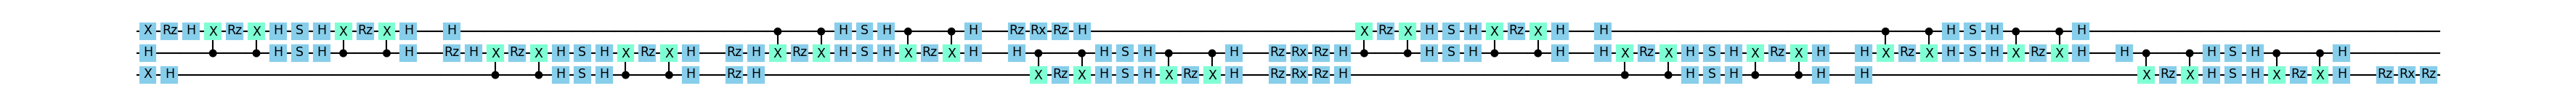

In [6]:
drawer = qai.matplotlib_drawer(circuit, dpi=300, scale=0.1)
drawer.draw_circuit()

### Compile the circuit

In [7]:
# Compiled the circuit by normal method
my_compilecircuit = circuit.compilecircuit(backend="pytorch_QUDIO")

in init


In [8]:
# # Compiled the circuit by hyper-optimized method
# from jdtensorpath import JDOptTN as jdopttn
# slicing_opts = None#{'target_size':2**28, 'repeats':500, 'target_num_slices':1, 'contract_parallel':False}
# hyper_opt = {'methods':['kahypar'], 'max_time':120, 'max_repeats':12, 'progbar':True, 'minimize':'flops', 'search_parallel':True, 'slicing_opts':slicing_opts}
# my_compilecircuit = circuit.compilecircuit(backend="pytorch", use_jdopttn=jdopttn, hyper_opt = hyper_opt, tn_simplify = False)

### Prepare the training data

In [9]:
params = torch.rand(n_qubits+1,2, requires_grad=True)


d_erg = torch.tensor(np.random.rand(int(n_train/2), N)*2-1)*h_erg*h_bar*t_d*math.pi
d_local = torch.tensor((np.random.rand(int(n_train/2), N)*39/40.+1/40.)*np.random.choice([-1., 1.], size=(int(n_train/2), N))*h_loc*h_bar*t_d*math.pi)
#d_local = torch.tensor(np.random.rand(int(n_train/2), N)*2-1)*h_loc*h_bar*t_d*math.pi
d = torch.cat((d_erg, d_local), 0)

y_target = torch.Tensor(np.array([1]*int(n_train/2)+[0]*int(n_train/2)))


### Train the QNN circuit

In [10]:
d


tensor([[ 3.3915e-01, -5.2313e-01,  2.9258e-01, -4.6383e-01],
        [-2.1220e-01,  6.1781e-02,  1.1261e-01,  6.0493e-01],
        [ 5.0245e-01, -4.8411e-01,  3.5173e-01, -5.3033e-01],
        [ 2.8220e-01, -2.2717e-02, -3.8766e-01, -4.9460e-01],
        [ 1.7406e-01,  5.1641e-01,  4.5241e-01, -2.1891e-01],
        [ 5.8923e-01,  7.8618e-02,  8.7832e-02, -2.8443e-01],
        [-7.5738e-02,  6.1832e-02, -2.1351e-01, -2.6155e-01],
        [-2.5337e-02, -4.2293e-01, -4.9735e-01,  6.1923e-01],
        [-5.9259e-01, -1.4063e-01, -4.7887e-01,  1.3906e-01],
        [-3.3319e-01, -3.0724e-01,  3.6941e-02,  6.2824e-01],
        [-2.2282e-01, -6.2590e-01, -3.4719e-01,  4.2145e-02],
        [-4.2919e-01, -4.4100e-01, -2.0915e-01, -3.8753e-01],
        [ 5.6477e-01,  2.2375e-01, -3.0780e-01, -4.2718e-01],
        [-1.0129e-01,  3.1633e-01, -3.2014e-01, -3.7809e-01],
        [-2.6289e-01, -7.0885e-02,  3.6482e-01,  8.3221e-02],
        [-1.2758e-01,  4.0522e-01,  1.3889e-01,  3.9279e-01],
        

In [11]:
my_compilecircuit.set_dataset(d)


Device count: 1


In [12]:
print(my_compilecircuit.device)

cpu


In [13]:
print(my_compilecircuit.dataset)

<bound method QUDIOBackend.dataset of <tedq.backends.qudio_backend.QUDIOBackend object at 0x16a8b2490>>


In [14]:
print(my_compilecircuit.dataset)
cir_params = torch.cat((params, -params[:,0].view(-1,1)),1)
print(cir_params)
y= my_compilecircuit(cir_params)
print(len(y),len(y_target))

<bound method QUDIOBackend.dataset of <tedq.backends.qudio_backend.QUDIOBackend object at 0x16a8b2490>>
tensor([[ 0.0626,  0.9421, -0.0626],
        [ 0.6268,  0.4481, -0.6268],
        [ 0.3601,  0.9411, -0.3601],
        [ 0.9733,  0.7448, -0.9733]], grad_fn=<CatBackward0>)
200 200


In [15]:
print(y_target)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])


In [16]:

optimizer = torch.optim.Adam([params], lr=0.5)

rnd_sq = np.arange(n_train)

# target_list = [0 for _ in range(n_train)]
y_list = [0 for _ in range(n_train)]

for epoch in range(n_epoch):
    np.random.shuffle(rnd_sq)
    l_sum = 0
    
#     w = y_target[i]*2+1
    loss = nn.BCELoss(reduction='mean')
    cir_params = torch.cat((params, -params[:,0].view(-1,1)),1)
    y = my_compilecircuit(cir_params)
#     print(len(y), len(y_target))
    
    
    diff = y[:,1]
    diff-= 0.6
# #     print(len(diff), len(y_target))
    
    diff[diff>0] = diff[diff>0]*5./4. + 0.5
    diff[diff<=0] = diff[diff<=0]*5./6. + 0.5
    
#     diff = y[0][1]
#     print(len(diff), len(y_target))

    l = loss(diff, y_target)
    l.backward()

    if epoch % 5 == 0:
        print(f'epoch {epoch + 1}: loss = {l:.8f}')
        print("acc:", np.sum(np.sum(((diff>0.5)==y_target).detach().numpy()))/n_train*100)
#         print("prediction:  ", (diff.detach().numpy()>0.5), "   ",y_target)

        
    params.grad = params.grad/n_train
    optimizer.step()
    optimizer.zero_grad()

epoch 1: loss = 0.60026067
acc: 50.0
epoch 6: loss = 0.53458005
acc: 82.5
epoch 11: loss = 0.54015154
acc: 87.0
epoch 16: loss = 0.53754419
acc: 80.0
epoch 21: loss = 0.53331584
acc: 83.0
epoch 26: loss = 0.53382146
acc: 83.5
epoch 31: loss = 0.53314394
acc: 82.0
epoch 36: loss = 0.53291285
acc: 82.5
epoch 41: loss = 0.53304178
acc: 84.5
epoch 46: loss = 0.53267753
acc: 83.0
epoch 51: loss = 0.53280795
acc: 83.0
epoch 56: loss = 0.53269351
acc: 83.0
epoch 61: loss = 0.53268111
acc: 83.0
epoch 66: loss = 0.53267652
acc: 83.0
epoch 71: loss = 0.53265524
acc: 83.0
epoch 76: loss = 0.53265816
acc: 83.0
epoch 81: loss = 0.53265661
acc: 83.0
epoch 86: loss = 0.53265083
acc: 83.0
epoch 91: loss = 0.53264987
acc: 83.0
epoch 96: loss = 0.53265035
acc: 83.0


### Test the trained circuit

In [17]:
d_erg = torch.tensor(np.random.rand(np.int(n_test/2), N)*2-1)*h_erg*h_bar*t_d*math.pi
d_local = torch.tensor(np.random.rand(np.int(n_test/2), N)*2-1)*h_loc*h_bar*t_d*math.pi
d = torch.cat((d_erg, d_local), 0)

my_compilecircuit.set_dataset(d)

y_target_test = torch.Tensor(np.array([1]*np.int(n_test/2)+[0]*np.int(n_test/2)))

l_sum=0


#     w = y_target[i]*2+1
cir_params = torch.cat((params, -params[:,0].view(-1,1)),1)
y = my_compilecircuit(cir_params)
#     print(len(y), len(y_target))

diff = y[:,1]
diff-= 0.6

diff[diff>0] = diff[diff>0]*5./4. + 0.5
diff[diff<=0] = diff[diff<=0]*5./6. + 0.5

print(f'loss = {l:.8f}')
print("acc:", np.sum(((diff>0.5)==y_target_test).detach().numpy())/n_test*100)
print("prediction:  ", (diff.detach().numpy()>0.5), "   ",y_target_test)

Device count: 1
loss = 0.53264958
acc: 78.0
prediction:   [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True False False False False False  True  True False  True False False
 False  True  True  True  True False  True False False False  True  True
 False  True]     tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
